# Reddit Comment Classification Model

This notebook implements a random forest model to classify comments based on sentiment analysis. Also, Logistic Regression and LinearSVC to compare with the RandomForest baseline.

## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

## Load preprocessed data

In [2]:
df = pd.read_csv("../data/processed/comments_lang_en.csv")

## Parameters

In [3]:
# List of offensive words for pseudo-labeling
bad_words = [
    "idiot", "stupid", "moron", "hate", "trash", "kill", "fuck", "dumb",
    "loser", "shut up", "disgusting", "ugly", "worthless", "pathetic",
    "suck", "annoying", "nonsense", "fool", "jerk", "bastard", "crap", "damn"
]

def pseudo_label(text):
    """Assigns a pseudo-label of 1 if any bad word is found in the text, else 0."""
    text = str(text).lower()
    return 1 if any(bad in text for bad in bad_words) else 0

# Apply pseudo-labeling to the 'text_ml' column
df["target"] = df["text_ml"].apply(pseudo_label)

## TF-IDF + VADER features

In [4]:
# Feature extraction
tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1,2))
X_tfidf = tfidf.fit_transform(df["text_ml"].fillna(""))

# Combine TF-IDF features with VADER sentiment scores
vader_feats = df[["vader_neg", "vader_neu", "vader_pos", "vader_compound"]].fillna(0).values
# Final feature matrix
X = np.hstack((X_tfidf.toarray(), vader_feats))
# Target variable
y = df["target"]

## Train/test split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Random Forest model

In [6]:
# Model training
model = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)
# Predictions
y_pred = model.predict(X_test)

## Model Performance

In [7]:
# Classification report
print(classification_report(y_test, y_pred, digits=2))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1827
           1       1.00      0.74      0.85       199

    accuracy                           0.97      2026
   macro avg       0.99      0.87      0.92      2026
weighted avg       0.98      0.97      0.97      2026



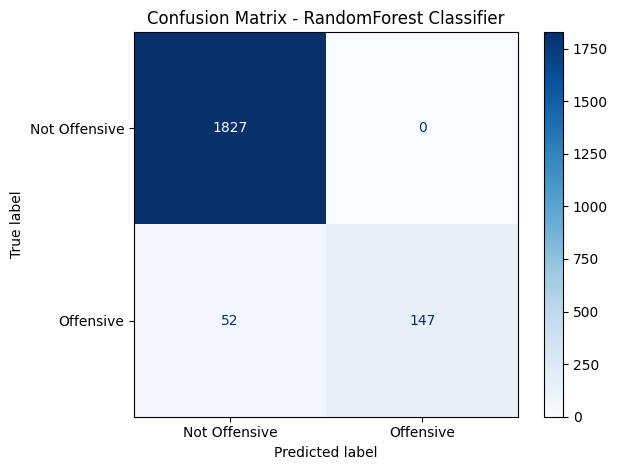

In [8]:
# Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Offensive","Offensive"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - RandomForest Classifier")
plt.tight_layout()
plt.savefig("../data/processed/figs/confusion_matrix.png", dpi=150)
plt.show()

In [9]:
from sklearn.linear_model import LogisticRegression

# Train Logistic Regression
clf_lr = LogisticRegression(max_iter=2000, class_weight='balanced', n_jobs=-1)
clf_lr.fit(X_train, y_train)
y_pred_lr = clf_lr.predict(X_test)
print('Logistic Regression')
print(classification_report(y_test, y_pred_lr, digits=2))

Logistic Regression
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      1827
           1       0.58      0.78      0.67       199

    accuracy                           0.92      2026
   macro avg       0.78      0.86      0.81      2026
weighted avg       0.94      0.92      0.93      2026



In [10]:
from sklearn.svm import LinearSVC

# Train LinearSVC
clf_svc = LinearSVC(class_weight='balanced', max_iter=10000)
clf_svc.fit(X_train, y_train)
y_pred_svc = clf_svc.predict(X_test)
print('LinearSVC')
print(classification_report(y_test, y_pred_svc, digits=2))

LinearSVC
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1827
           1       0.74      0.79      0.76       199

    accuracy                           0.95      2026
   macro avg       0.86      0.88      0.87      2026
weighted avg       0.95      0.95      0.95      2026



In [11]:
# Summary comparison (precision, recall, f1)
from sklearn.metrics import precision_score, recall_score, f1_score
results = pd.DataFrame({
    'model': ['RandomForest','LogisticRegression','LinearSVC'],
    'precision': [None, None, None],
    'recall': [None, None, None],
    'f1': [None, None, None]
})

In [12]:
# fill metrics; existing 'y_pred' is RandomForest predictions
results.loc[results.model=='RandomForest', ['precision','recall','f1']] = [
    precision_score(y_test, y_pred, zero_division=0),
    recall_score(y_test, y_pred, zero_division=0),
    f1_score(y_test, y_pred, zero_division=0)
]
results.loc[results.model=='LogisticRegression', ['precision','recall','f1']] = [
    precision_score(y_test, y_pred_lr, zero_division=0),
    recall_score(y_test, y_pred_lr, zero_division=0),
    f1_score(y_test, y_pred_lr, zero_division=0)
]
results.loc[results.model=='LinearSVC', ['precision','recall','f1']] = [
    precision_score(y_test, y_pred_svc, zero_division=0),
    recall_score(y_test, y_pred_svc, zero_division=0),
    f1_score(y_test, y_pred_svc, zero_division=0)
]
print(results)

                model precision    recall        f1
0        RandomForest       1.0  0.738693  0.849711
1  LogisticRegression  0.579926   0.78392  0.666667
2           LinearSVC  0.737089  0.788945  0.762136


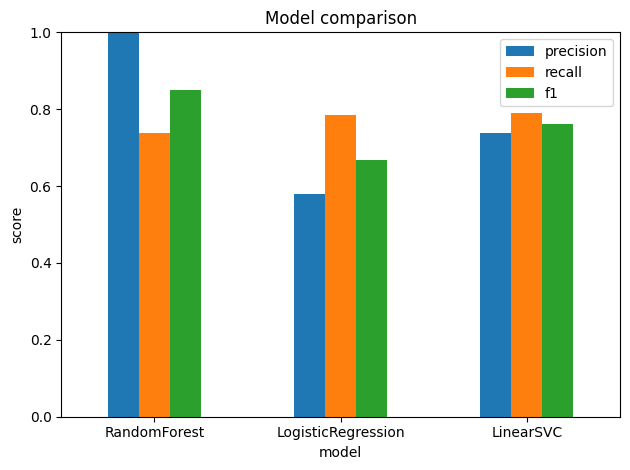

In [13]:
# Quick bar plot comparison
results.set_index('model')[['precision','recall','f1']].plot.bar(rot=0)
plt.title('Model comparison')
plt.ylabel('score')
plt.ylim(0,1)
plt.tight_layout()
plt.savefig('../data/processed/figs/model_comparison.png', dpi=150)
plt.show()

In [32]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from unidecode import unidecode
import regex as rx
import re
import numpy as np

RE_URL = re.compile(r"https?://\S+", re.I)
RE_NON_ALNUM = rx.compile(r"[^\p{L}\p{N}\s]", rx.UNICODE)
RE_WS = re.compile(r"\s+")

def minimal_clean_for_vader(text: str) -> str:
    if not isinstance(text, str):
        return ""
    t = RE_URL.sub("URL", text)
    t = RE_WS.sub(" ", t).strip()
    return t

def clean_text_ml(text: str, lang: str = "en") -> str:
    if not isinstance(text, str):
        return ""
    t = RE_URL.sub(" ", text)
    t = re.sub(r"\bu/\w+", " ", t)
    t = re.sub(r"\br/\w+", " ", t)
    t = rx.sub(r"[\p{C}\p{Zl}\p{Zp}]", " ", t)
    t = RE_NON_ALNUM.sub(" ", t)
    t = RE_WS.sub(" ", t).strip()
    t = t.lower()
    t = unidecode(t)
    return t

comment = input("Enter comment (leave empty to use example): ").strip()
if not comment:
    comment = "This is a sample comment to test the classifier."

text_ml = clean_text_ml(comment, "en")
try:
    tfidf_vec = tfidf.transform([text_ml]).toarray()
except NameError:
    raise RuntimeError("`tfidf` not found. Run the TF-IDF / training cells first.")

analyzer = SentimentIntensityAnalyzer()
v = analyzer.polarity_scores(minimal_clean_for_vader(comment))
v_feats = np.array([[v["neg"], v["neu"], v["pos"], v["compound"]]])
X_single = np.hstack((tfidf_vec, v_feats))

clf = globals().get("model") or globals().get("clf_lr") or globals().get("clf_svc")
if clf is None:
    raise RuntimeError("No trained model found (e.g., `model`, `clf_lr`, `clf_svc`). Run training cells first.")

pred = clf.predict(X_single)[0]
label_map = {0: "Not Offensive", 1: "Offensive"}

print("=== Input ===")
print(comment)
print("\n=== Cleaned (text_ml) ===")
print(text_ml)
print("\n=== Prediction ===")
print(f"Label: {label_map.get(pred, pred)} (raw: {pred})")
if hasattr(clf, "predict_proba"):
    proba = clf.predict_proba(X_single)[0]
    if proba.size == 2:
        print(f"Probabilities -> Not Offensive: {proba[0]:.3f}, Offensive: {proba[1]:.3f}")
    else:
        print("Probabilities:", proba)


=== Input ===
see this article for details: https://example.com/research-on-topic

=== Cleaned (text_ml) ===
see this article for details

=== Prediction ===
Label: Not Offensive (raw: 0)
Probabilities -> Not Offensive: 0.990, Offensive: 0.010
